In [1]:
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np
import pandas as pd
import os 
import re

from bids import BIDSLayout
from mne_ari import all_resolutions_inference
import mne

In [2]:
# hard-coded values
BIDS_ROOT = 'bids_dataset'
DERIV_ROOT = os.path.join(BIDS_ROOT, 'derivatives')

In [3]:
layout = BIDSLayout(BIDS_ROOT, derivatives = True)
subjects = layout.get_subjects(scope = 'preprocessing')
subjects.sort()
task = layout.get_tasks()[0]

/home/johnv/anaconda3/envs/agency/lib/python3.10/site-packages/bids/layout/validation.py:156: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


In [4]:
def load_subj_data(layout, sub):
    
    evoked_fpath = layout.get(
        scope = 'preprocessing', 
        subject = sub, 
        suffix = 'ave', 
        extension = 'fif.gz', 
        return_type = 'filename')[0]
    evokeds = mne.read_evokeds(evoked_fpath, verbose = False)
    agency = evokeds[0].crop(tmin = -.025).apply_baseline(verbose = False)
    non_agency = evokeds[1].crop(tmin = -.025).apply_baseline(verbose = False)
    diff = mne.combine_evoked(
        [agency, non_agency],
        weights = [1, -1]
    )
    lowpass = diff.info['lowpass']
    diff = diff.resample(lowpass * 2)
    return agency, non_agency, diff

In [5]:
agency = []
non_agency = []
diff = []
for sub in subjects:
    out = load_subj_data(layout, sub)
    agency.append(out[0])
    non_agency.append(out[1])
    diff.append(out[2])
ave_agency = mne.grand_average(agency)
ave_non_agency = mne.grand_average(non_agency)
ave_diff = mne.grand_average(diff)

Identifying common channels ...
Identifying common channels ...
Identifying common channels ...


No projector specified for this dataset. Please consider the method self.add_proj.


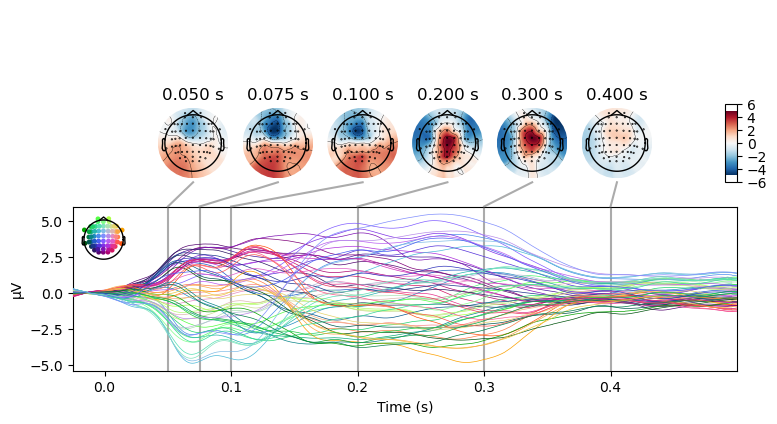

In [6]:
all_trials = mne.combine_evoked([ave_agency, ave_non_agency], weights = 'nave')
all_trials.nave = None
dig = mne.channels.make_standard_montage('standard_1020')
all_trials = all_trials.set_montage(dig)
fig = all_trials.plot_joint([.05, .075, .1, .2, .3, .4], title = ' ', show = False)
plt.savefig('evoked.png', dpi = 500, bbox_inches = 'tight')
plt.show()

In [7]:
# format for ARI
X = np.stack([ev.get_data() for ev in diff])
X = np.transpose(X, (0, 2, 1))  # transpose for clustering
X.shape

(23, 32, 62)

In [8]:
from mne.channels import find_ch_adjacency
from mne_ari import all_resolutions_inference

alpha = .05
neighb, _ = find_ch_adjacency(all_trials.info, "eeg")
p_vals, tdp, clusters = all_resolutions_inference(
    X, tail = 0, # two-sided
    adjacency = neighb
)

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 62


/tmp/ipykernel_432976/2501284934.py:3: RuntimeWarning: `mask` is None, not masking the plot ...
  im, _ = _plot_masked_image(
/tmp/ipykernel_432976/2501284934.py:3: RuntimeWarning: `mask` is None, not adding contour to the plot ...
  im, _ = _plot_masked_image(
/tmp/ipykernel_432976/2501284934.py:15: RuntimeWarning: `mask` is None, not masking the plot ...
  im, _ = _plot_masked_image(
/tmp/ipykernel_432976/2501284934.py:15: RuntimeWarning: `mask` is None, not adding contour to the plot ...
  im, _ = _plot_masked_image(


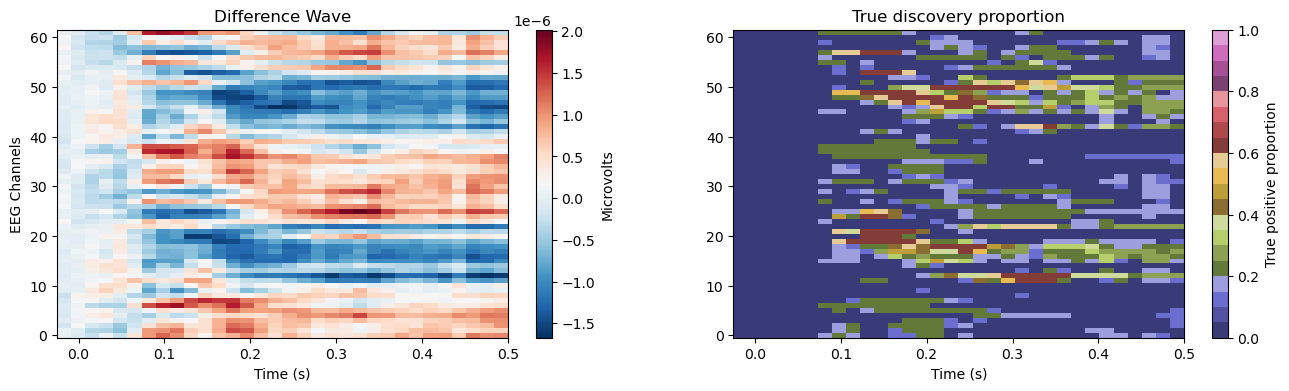

In [9]:
from mne.viz.utils import _plot_masked_image
fig, ax = plt.subplots(1, 2, figsize = (16, 4))
im, _ = _plot_masked_image(
    ax[0], 
    X.mean(0).T, 
    times = all_trials.times, 
    #mask = tdp.T > .4
)
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('EEG Channels')
ax[0].set_title('Difference Wave')
cbar = plt.colorbar(im, ax = ax[0])
cbar.set_label('Microvolts')

im, _ = _plot_masked_image(
    ax[1], 
    tdp.T, 
    times = all_trials.times, 
    cmap = 'tab20b',
    vmin = 0., vmax = 1.
)
ax[1].set_xlabel('Time (s)')
ax[1].set_title('True discovery proportion')
cbar = plt.colorbar(im, ax = ax[1])
cbar.set_label('True positive proportion')

plt.show()